# ASSOCIATION RULES LEARNING

## Importing Modules & Dataset

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)
!pip install mlxtend
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns


Defaulting to user installation because normal site-packages is not writeable


In [5]:
df = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")

In [6]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
df.shape

(541910, 8)

### Functions

In [8]:
def check(df, head = 5):
    print("**********************************HEAD**********************************")
    print(df.head(head))
    print("**********************************TAIL**********************************")
    print(df.tail(head))
    print("**********************************TYPES**********************************")
    print(df.dtypes)
    print("**********************************SHAPE**********************************")
    print(df.shape)
    print("**********************************NA**********************************")
    print(df.isnull().sum())
    print("**********************************QUANTILES**********************************")
    print(df.describe([0, 0.05, 0.5, 0.95]))

In [9]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [10]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

In [11]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

In [12]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [13]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [14]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape)
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index


In [15]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [16]:
#Replacing may be more useful if removing entire row is not desired
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [17]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


In [18]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [19]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [20]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [21]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [22]:
def high_correlated_cols(df, plot=False, corr_th = 0.9):
    corr  = df.corr()
    corr_matrix = corr.abs()
    upper_traingle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1 ).astype(np.bool))
    drop_list = [col for col in upper_traingle_matrix.columns if any(upper_traingle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={"figure.figsize" : (15,15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
        
    return drop_list

In [23]:
#Relationship between the target feature and missing values
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

## Exploratory Data Analysis

In [24]:
check(df)

**********************************HEAD**********************************
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00   2.55      17850.0  United Kingdom
1  536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00   2.75      17850.0  United Kingdom
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00   3.39      17850.0  United Kingdom
**********************************TAIL**********************************
       Invoice StockCode                      Description  Quantity         InvoiceDate  Price  Customer ID Country


In [25]:
df.dropna(inplace=True)

In [26]:
cats,nums,cards = grab_col_names(df)

Observations: 406830
Variables: 8
cat_cols: 0
num_cols: 4
cat_but_car: 4
num_but_cat: 0


count    406830.000000
mean         12.061276
std         248.693065
min      -80995.000000
5%            1.000000
10%           1.000000
20%           1.000000
30%           2.000000
40%           3.000000
50%           5.000000
60%           6.000000
70%          12.000000
80%          12.000000
90%          24.000000
95%          36.000000
99%         120.000000
max       80995.000000
Name: Quantity, dtype: float64


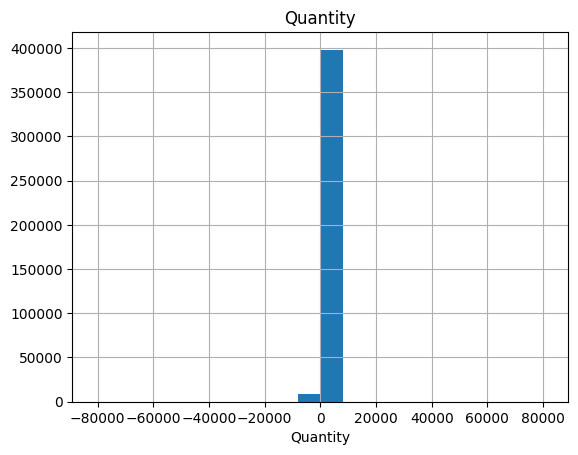

None
count                  406830
unique                  20460
top       2011-11-14 15:27:00
freq                      543
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object


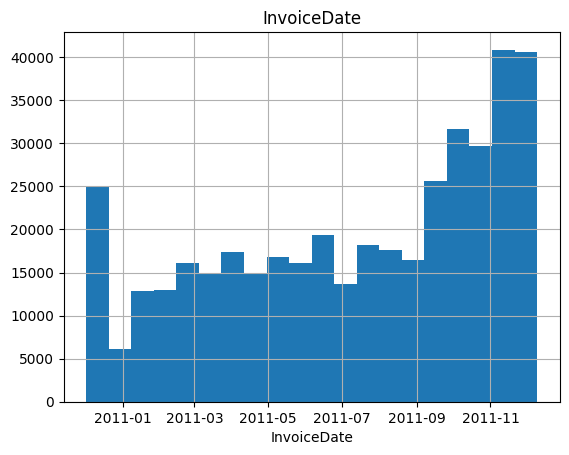

None
count    406830.000000
mean          3.460507
std          69.315080
min           0.000000
5%            0.420000
10%           0.550000
20%           0.850000
30%           1.250000
40%           1.650000
50%           1.950000
60%           2.100000
70%           2.950000
80%           4.150000
90%           6.750000
95%           8.500000
99%          15.000000
max       38970.000000
Name: Price, dtype: float64


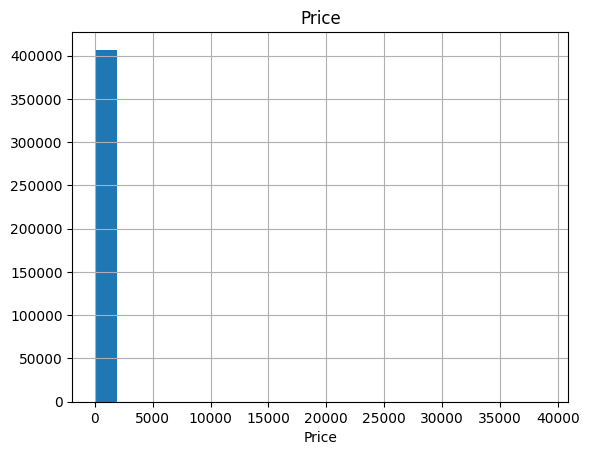

None
count    406830.000000
mean      15287.684160
std        1713.603074
min       12346.000000
5%        12626.000000
10%       12876.000000
20%       13536.000000
30%       14159.000000
40%       14659.000000
50%       15152.000000
60%       15805.000000
70%       16493.000000
80%       17095.000000
90%       17719.000000
95%       17905.000000
99%       18212.000000
max       18287.000000
Name: Customer ID, dtype: float64


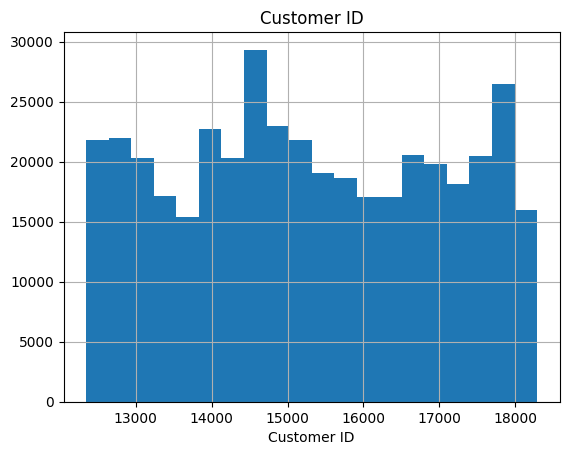

None


In [27]:
for col in nums:
    print(num_summary(df, col, plot =True))

In [28]:
for col in nums:
    print(f"{col} : {check_outlier(df, col)}")

Quantity : True
InvoiceDate : False
Price : True
Customer ID : False


In [29]:
for col in nums:
    df = remove_outlier(df, col)

In [30]:
for col in nums:
    print(f"{col} : {check_outlier(df, col)}")

Quantity : False
InvoiceDate : False
Price : True
Customer ID : False


In [31]:
df = df[df.Price > 0]

In [32]:
df = df[df.Country == "France"]

In [33]:
df.shape

(6991, 8)

In [34]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France
29,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0,France
30,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0,France


In [35]:
df.groupby(['Invoice', 'Description']).agg({"Quantity": "sum"}).head(20)

Quantity
Invoice Description                                  
536370   SET 2 TEA TOWELS I LOVE LONDON            24
        ALARM CLOCK BAKELIKE GREEN                 12
        ALARM CLOCK BAKELIKE PINK                  24
        ALARM CLOCK BAKELIKE RED                   24
        CHARLOTTE BAG DOLLY GIRL DESIGN            20
        CIRCUS PARADE LUNCH BOX                    24
        LUNCH BOX I LOVE LONDON                    24
        MINI JIGSAW CIRCUS PARADE                  24
        MINI JIGSAW SPACEBOY                       24
        PANDA AND BUNNIES STICKER SHEET            12
        RED TOADSTOOL LED NIGHT LIGHT              24
        ROUND SNACK BOXES SET OF4 WOODLAND         24
        SET/2 RED RETROSPOT TEA TOWELS             18
        SPACEBOY LUNCH BOX                         24
        STARS GIFT TAPE                            24
        VINTAGE HEADS AND TAILS CARD GAME          24
        VINTAGE SEASIDE JIGSAW PUZZLES             12
536852  CHARLOTTE BAG DOLLY GIRL DESIGN            10
        MINI JIGSAW DOLLY GIRL                     24
        MINI JIGSAW SPACEBOY                       24

In [36]:
df.groupby(['Invoice', 'Description']).agg({"Quantity": "sum"}).unstack().fillna(0)

Quantity                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [37]:

def create_invoice_product_df(dataframe, id=False):
    if id:
        return dataframe.groupby(['Invoice', "StockCode"])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)
    else:
        return dataframe.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)

In [38]:
df_f = create_invoice_product_df(df, id=True)

In [39]:
df_f.iloc[:10, :10]

StockCode,10002,10120,10125,10135,11001,15036,15039,16012,16048,16225
Invoice,,,,,,,,,,
536370,0,0,0,0,0,0,0,0,0,0
536852,0,0,0,0,0,0,0,0,0,0
536974,0,0,0,0,0,0,0,0,0,0
537065,0,0,0,0,0,0,0,0,0,0
537463,0,0,0,0,0,0,0,0,0,0
537468,0,0,0,0,0,0,0,0,0,0
537693,0,0,0,0,0,0,0,0,0,0
537897,0,0,0,0,0,0,0,0,0,0
537967,0,0,0,0,0,0,0,0,0,0


In [40]:
frequent_itemsets = apriori(df_f,
                            min_support=0.01,
                            use_colnames=True)

/usr/local/lib/python3.8/dist-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [41]:
frequent_itemsets.sort_values("support", ascending=False)

,support,itemsets
98,0.157895,(21731)
220,0.157895,(22556)
218,0.155388,(22554)
166,0.152882,(22326)
173,0.140351,(22352)
...,...,...
9318,0.010025,"(21086, 22029, 21558, 22551)"
9319,0.010025,"(21987, 21988, 21086, 21559)"
9322,0.010025,"(21989, 21987, 22437, 21086)"
9324,0.010025,"(22352, 22029, 21086, 22303)"


In [42]:
rules = association_rules(frequent_itemsets,
                          metric="support",
                          min_threshold=0.01)

In [45]:
rules.sort_values(by="support", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1150,(21086),(21094),0.112782,0.107769,0.100251,0.888889,8.248062,0.088096,8.030075
1151,(21094),(21086),0.107769,0.112782,0.100251,0.930233,8.248062,0.088096,12.716792
4492,(22554),(22556),0.155388,0.157895,0.092732,0.596774,3.779570,0.068197,2.088421
4493,(22556),(22554),0.157895,0.155388,0.092732,0.587302,3.779570,0.068197,2.046559
4320,(22554),(22551),0.155388,0.120301,0.090226,0.580645,4.826613,0.071532,2.097744
...,...,...,...,...,...,...,...,...,...
223190,"(22352, 22554, 22726, 22303)","(22556, 21558)",0.010025,0.022556,0.010025,1.000000,44.333333,0.009799,inf
223189,"(22352, 22554, 22556, 22726)","(21558, 22303)",0.010025,0.012531,0.010025,1.000000,79.800000,0.009899,inf
223188,"(22352, 22303, 22726, 21558)","(22554, 22556)",0.010025,0.092732,0.010025,1.000000,10.783784,0.009095,inf
223187,"(22352, 22556, 22726, 21558)","(22554, 22303)",0.012531,0.025063,0.010025,0.800000,31.920000,0.009711,4.874687
